<a href="https://colab.research.google.com/github/VinceChin/-/blob/master/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Definition


In [3]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00


In [55]:
import torch
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels, num_classes):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(1, hidden_channels) # we only use degree as feature
    self.conv2 = GCNConv(hidden_channels, num_classes)

  def forward(self, x, edge_index, edge_weight):
    x = F.relu(self.conv1(x, edge_index, edge_weight))
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index, edge_weight)
    return x

def predicted_edges(node_embeddings, edge_index):
  if edge_index.shape[0] != 2:
    raise ValueError(f"Expected edge_index with shape [2, E], but got {edge_index.shape}")
  try:
    edge_preds = (node_embeddings[edge_index[0]] * node_embeddings[edge_index[1]])
  except:
    print(node_embeddings[edge_index[0]] * node_embeddings[edge_index[1]])
  return torch.sigmoid(edge_preds)

# Training

## Load Graph Data

In [11]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from torch_geometric.utils import degree
from torch_geometric.data import Data

def load_data_with_degree_features(filepath):
    data_df = pd.read_csv(filepath)

    # convert node to index
    encoder = LabelEncoder()
    source_encoded = encoder.fit_transform(data_df['source'])
    target_encoded = encoder.fit_transform(data_df['target'])

    # create edge index
    edge_index_np = np.vstack([source_encoded, target_encoded])
    edge_index = torch.tensor(edge_index_np, dtype=torch.long)

    # load edge weight
    edge_weight = torch.tensor(data_df['weight'].values, dtype=torch.float)

    # calculate degree for each node
    num_nodes = max(source_encoded.max(), target_encoded.max()) + 1
    node_degree = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.float)

    # add label for prediction
    y = (edge_weight > 0).float()

    # create node
    graph_data = Data(x=node_degree.unsqueeze(1),  # use degree as feature
                      edge_index=edge_index,
                      edge_attr=edge_weight,
                      y=y)

    return graph_data

train_file = 'weblog_train.csv'
train_data = load_data_with_degree_features(train_file)
print("Max node index in edge_index:", train_data.edge_index.max().item())
print("Number of nodes in train_data:", train_data.num_nodes)
print("Number of edges in train_data:", train_data.num_edges)

val_file = 'weblog_val.csv'
val_data = load_data_with_degree_features(val_file)
print("Max node index in edge_index:", val_data.edge_index.max().item())
print("Number of nodes in val_data:", val_data.num_nodes)
print("Number of edges in val_data:", val_data.num_edges)

test_file = 'weblog_test.csv'
test_data = load_data_with_degree_features(test_file)
print("Max node index in edge_index:", test_data.edge_index.max().item())
print("Number of nodes in test_data:", test_data.num_nodes)
print("Number of edges in test_data:", test_data.num_edges)

Max node index in edge_index: 206
Number of nodes in train_data: 207
Number of edges in train_data: 431
Max node index in edge_index: 97
Number of nodes in val_data: 98
Number of edges in val_data: 123
Max node index in edge_index: 53
Number of nodes in test_data: 54
Number of edges in test_data: 62


## Training & Loss Figure

Epoch 1, Loss: 1.6038, Val Loss:0.4634
Epoch 2, Loss: 1.2448, Val Loss:0.4830
Epoch 3, Loss: 1.4409, Val Loss:0.5078
Epoch 4, Loss: 1.5407, Val Loss:0.5274
Epoch 5, Loss: 0.7975, Val Loss:0.5430
Epoch 6, Loss: 1.0132, Val Loss:0.5590
Epoch 7, Loss: 0.8244, Val Loss:0.5731
Epoch 8, Loss: 0.5661, Val Loss:0.5851
Epoch 9, Loss: 0.7370, Val Loss:0.5930
Epoch 10, Loss: 1.1992, Val Loss:0.5974
Epoch 11, Loss: 0.5952, Val Loss:0.5997
Epoch 12, Loss: 0.5740, Val Loss:0.6022
Epoch 13, Loss: 0.8988, Val Loss:0.6037
Epoch 14, Loss: 0.5788, Val Loss:0.6046
Epoch 15, Loss: 0.7828, Val Loss:0.6068
Epoch 16, Loss: 0.5524, Val Loss:0.6068
Epoch 17, Loss: 1.0355, Val Loss:0.6066
Epoch 18, Loss: 0.7435, Val Loss:0.6066
Epoch 19, Loss: 0.8107, Val Loss:0.6059
Epoch 20, Loss: 0.5231, Val Loss:0.6045
Epoch 21, Loss: 0.7670, Val Loss:0.6033
Epoch 22, Loss: 0.5362, Val Loss:0.6008
Epoch 23, Loss: 0.9864, Val Loss:0.5980
Epoch 24, Loss: 0.5303, Val Loss:0.5937
Epoch 25, Loss: 0.7437, Val Loss:0.5899
Epoch 26,

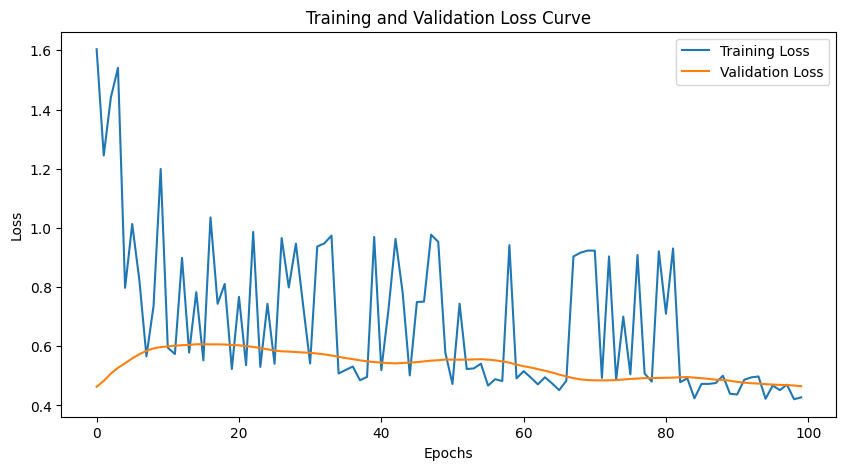

torch.Size([54, 1])
Test ROC AUC Score: 0.7180
torch.Size([207, 1])
Train ROC AUC Score: 0.6451


In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import random

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(42)

model = GCN(hidden_channels=16, num_classes=1)  # binary classification

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

loss_values = []  # store loss for every epoch
val_loss_values = []

def train(data):
    model.train()
    optimizer.zero_grad()
    node_embedding = model(data.x, data.edge_index, data.edge_attr)
    out = predicted_edges(node_embedding, data.edge_index)
    loss = criterion(out.squeeze(), data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(data):
    model.eval()
    with torch.no_grad():
        node_embedding = model(data.x, data.edge_index, data.edge_attr)
        out = predicted_edges(node_embedding, data.edge_index)
        loss = criterion(out.squeeze(), data.y)
    return loss.item()

def evaluate_roc(data):
    model.eval()
    with torch.no_grad():
      print(data.x.shape)
      node_embedding = model(data.x, data.edge_index, data.edge_attr).squeeze()
      out = predicted_edges(node_embedding, data.edge_index)

    roc_score = roc_auc_score(data.y.cpu().numpy(), out.cpu().numpy())
    return roc_score

for epoch in range(100):
    loss = train(train_data)
    val_loss = evaluate(val_data)
    loss_values.append(loss)
    val_loss_values.append(val_loss)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Val Loss:{val_loss:.4f}')



# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

test_roc_auc = evaluate_roc(test_data)
print(f'Test ROC AUC Score: {test_roc_auc:.4f}')
train_roc_auc = evaluate_roc(train_data)
print(f'Train ROC AUC Score: {train_roc_auc:.4f}')
